# Exploratory Data Analysis

The objective of this notebook is to identify key drivers of electricity prices and formulate testable hypotheses based on supply-demand dynamics by doing the following:
1. Identify trends and periodic behaviour
2. Study correlations between variables
3. Formulate hypotheses

Users can run `scripts/create_datasets.py` to create the datasets used in this notebook.

## 1. Identify trends and periodic behaviour

We will do this by visualising the data over different time scales.

In [ ]:
# Load datasets
import os
import pandas as pd
import numpy as np

base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")
df_electricity = pd.read_csv(os.path.join(base_dir, "electricity_data.csv"))
df_weather = pd.read_csv(os.path.join(base_dir, "weather_data.csv"))

# Make sure dataset timestamps are pandas.Timestamp objects
df_electricity['startTime'] = pd.to_datetime(df_electricity['startTime'])
df_weather['ob_time'] = pd.to_datetime(df_weather['ob_time'])

print(f"Electricity data memory usage: {np.sum(df_electricity.memory_usage()) / 10**6} MB")
print(f"Weather data memory usage: {np.sum(df_weather.memory_usage()) / 10**6} MB")

print("\nElectricity data columns:\n", df_electricity.columns)
print("\nWeather data columns:\n", df_weather.columns)

Electricity data memory usage: 8.548612 MB
Weather data memory usage: 5.886628 MB

Electricity data columns:
 Index(['settlementDate', 'settlementPeriod', 'startTime', 'BIOMASS', 'GAS',
       'COAL', 'OIL', 'NUCLEAR', 'SOLAR', 'WIND', 'OTHER', 'INTER', 'INDO',
       'ITSO', 'price', 'volume'],
      dtype='object')

Weather data columns:
 Index(['ob_time', 'wind_speed', 'wind_direction', 'visibility',
       'air_temperature', 'glbl_irad_amt', 'location'],
      dtype='object')


In [ ]:
df_electricity.head()

,settlementDate,settlementPeriod,startTime,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,INTER,INDO,ITSO,price,volume
0,2024-12-30,1,2024-12-30 00:00:00+00:00,1773.0,2613.0,0.0,0.0,5060.0,0.0,15439.206,979.0,356,21609.0,26087.0,45.25,1902.45
1,2024-12-30,2,2024-12-30 00:30:00+00:00,1779.0,2838.0,0.0,0.0,5062.0,0.0,15555.567,1097.0,496,22108.0,26692.0,49.17,1711.10
2,2024-12-30,3,2024-12-30 01:00:00+00:00,1779.0,2721.0,0.0,0.0,5056.0,0.0,15462.104,988.0,1022,21579.0,26551.0,37.83,2097.45
3,2024-12-30,4,2024-12-30 01:30:00+00:00,1780.0,2514.0,0.0,0.0,5069.0,0.0,15294.455,991.0,1026,21054.0,26270.0,30.41,2079.45
4,2024-12-30,5,2024-12-30 02:00:00+00:00,1666.0,2555.0,0.0,0.0,5062.0,0.0,15203.118,1129.0,568,20539.0,25998.0,27.06,2332.20


In [ ]:
df_weather.head()

,ob_time,wind_speed,wind_direction,visibility,air_temperature,glbl_irad_amt,location
0,2021-01-01 00:00:00,1.028,360.0,500.0,0.5,0.0,Heathrow
1,2021-01-01 01:00:00,1.028,340.0,350.0,0.2,0.0,Heathrow
2,2021-01-01 02:00:00,1.028,320.0,400.0,0.2,0.0,Heathrow
3,2021-01-01 03:00:00,2.056,280.0,320.0,0.0,0.0,Heathrow
4,2021-01-01 04:00:00,2.056,290.0,250.0,-0.2,0.0,Heathrow


Plot electricity generation breakdown:

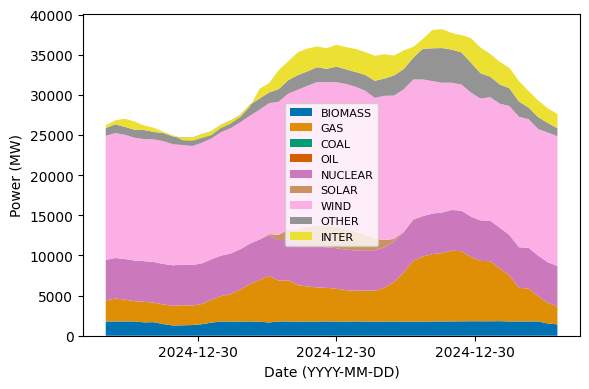

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-v0_8-colorblind')

from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter

generation_types = ['BIOMASS', 'GAS','COAL', 'OIL', 'NUCLEAR', 'SOLAR', 'WIND', 'OTHER', 'INTER']

colors = sns.color_palette("colorblind", len(generation_types))
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')

# note that data is downsampled
ax.stackplot(df_electricity['startTime'][-100:], [df_electricity[gt][-100:] for gt in generation_types], labels=generation_types, colors=colors)

ax.legend(fontsize=8)
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))  # Max ~10 ticks
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))  # e.g., 2022-01-15
ax.set_xlabel('Date (YYYY-MM-DD)', fontsize=10)
ax.set_ylabel('Power (MW)', fontsize=10)
plt.show()

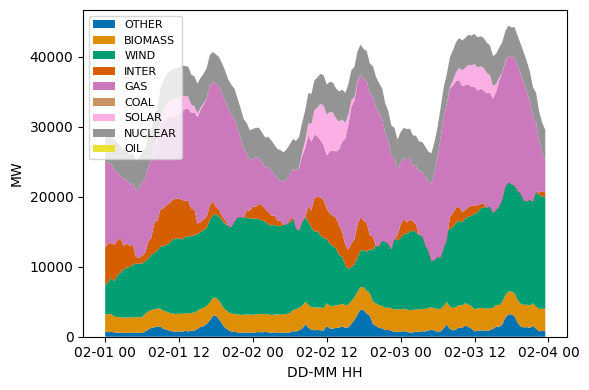

In [12]:
colors = sns.color_palette("colorblind", len(generation_types))
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
ax.stackplot(df_generation['startTime'], [df_generation[gt] for gt in generation_types], labels=generation_types, colors=colors)
ax.legend(fontsize=8)
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.show()

Plot demand with the generation data:

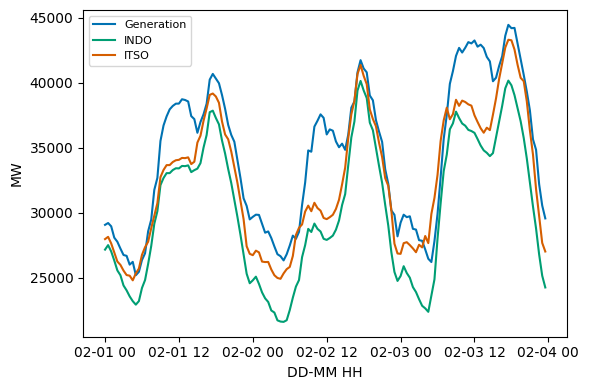

In [15]:
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
ax.plot(df_generation['startTime'], df_generation[list(generation_types)].sum(axis=1), label='Generation')
ax.plot(df_demand['startTime'], df_demand['INDO'], label='INDO')
ax.plot(df_demand['startTime'], df_demand['ITSO'], label='ITSO')
ax.legend(fontsize=8)
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.show()

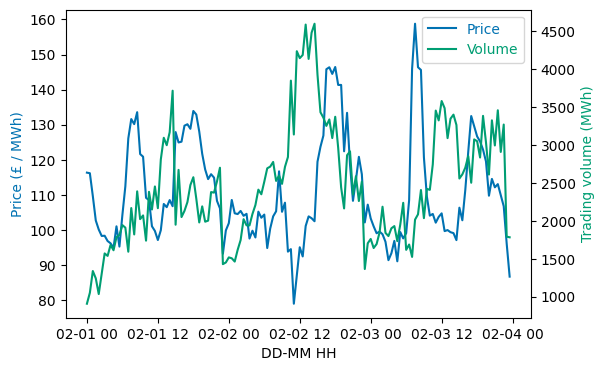

In [18]:
# Plot price and trading volume on twin axes
from mpl_toolkits.axes_grid1 import host_subplot

plt.figure(figsize=(6,4))
host = host_subplot(111)
par = host.twinx()

host.set_xlabel("DD-MM HH", fontsize=10)
host.set_ylabel("Price (£ / MWh)", fontsize=10)
par.set_ylabel("Trading volume (MWh)", fontsize=10)

p1, = host.plot(df_price['startTime'], df_price['price'], label="Price")
p2, = par.plot(df_price['startTime'], df_price['volume'], label="Volume")

host.legend(labelcolor="linecolor")

host.yaxis.label.set_color(p1.get_color())
par.yaxis.label.set_color(p2.get_color())

plt.show()

Plot temperature and wind speed:

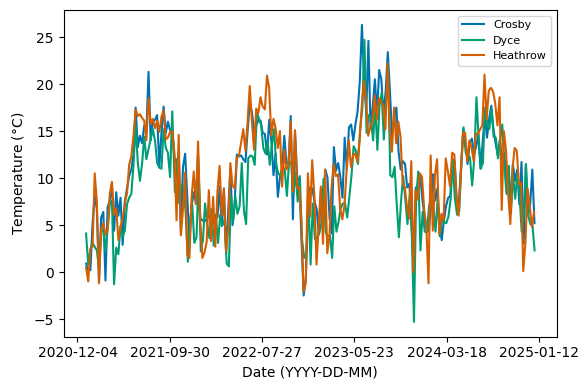

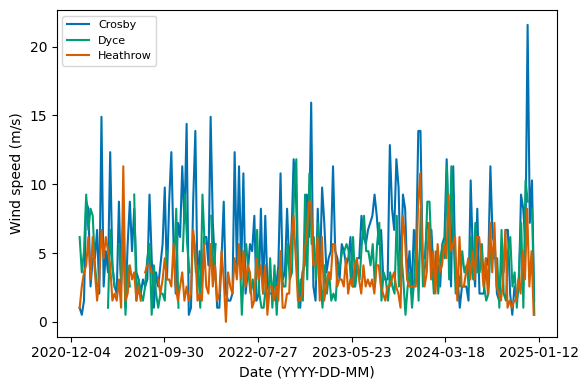

In [ ]:
from matplotlib.ticker import MaxNLocator

locations = ['Heathrow', 'Crosby', 'Dyce']

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
for location, group in df_weather.groupby('location'):
    # downsample data to weekly frequency
    timedata = group['ob_time'][::7*24]
    tempdata = group['air_temperature'][::7*24]
    ax.plot(timedata, tempdata, label=location)
ax.legend(fontsize=8)
ax.set_xlabel('Date (YYYY-DD-MM)', fontsize=10)
ax.set_ylabel('Temperature ($\\degree \\mathrm{C}$)', fontsize=10)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Max ~10 ticks
plt.show()

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
for location, group in df_weather.groupby('location'):
    # downsample data to weekly frequency
    timedata = group['ob_time'][::7*24]
    tempdata = group['wind_speed'][::7*24]
    ax.plot(timedata, tempdata, label=location)
ax.legend(fontsize=8)
ax.set_xlabel('Date (YYYY-DD-MM)', fontsize=10)
ax.set_ylabel('Wind speed (m/s)', fontsize=10)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Max ~10 ticks
plt.show()

Plot price with demand and generation data:

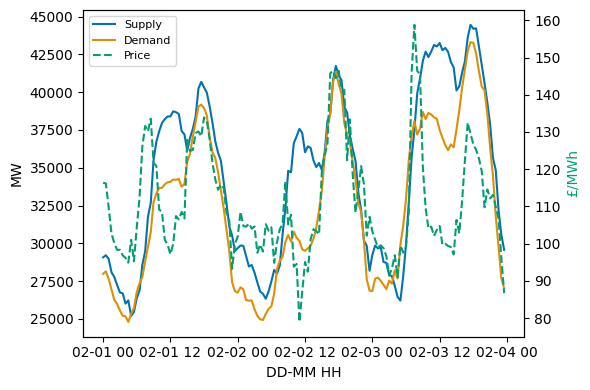

In [20]:
total_generation = df_generation[list(generation_types)].sum(axis=1)

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')

colors = sns.color_palette("colorblind", 3)

# Left axis - Power
ax.plot(df_generation['startTime'], total_generation, label='Supply', color=colors[0])
ax.plot(df_demand['startTime'], df_demand['ITSO'], label='Demand', color=colors[1])
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)

# Right axis - Price
ax2 = ax.twinx()
ax2.plot(df_price['startTime'], df_price['price'], label='Price', linestyle='--', color=colors[2])
ax2.set_ylabel('£/MWh', fontsize=10, color=colors[2])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)

plt.show()

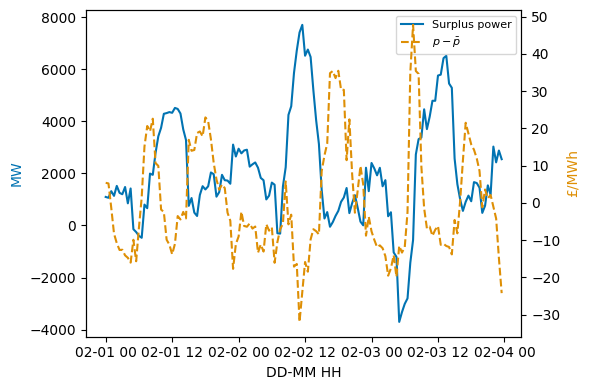

In [21]:
surplus = total_generation - df_demand['ITSO']
mean_price = np.mean(df_price['price'])

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')

# plot power surplus, i.e. energy generation - energy demand
ax.plot(df_generation['startTime'], surplus, label='Surplus power', color=colors[0])
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10, color=colors[0])
ax.legend(fontsize=8)

# plot price fluctuation from mean
ax2 = ax.twinx()
ax2.plot(df_price['startTime'], df_price['price'] - mean_price, label='$p - \\bar{p}$', linestyle='--', color=colors[1])
ax2.set_ylabel('£/MWh', fontsize=10, color=colors[1])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)
plt.show()

- For generated power larger than the demand for power, 'surplus power' is positive.
- For generated power smaller than the demand for power, 'surplus power' is negative.

In the previous plot, we see that prices are much higher than the mean when surplus power is large and negative, while prices are low when surplus power is large and positive. When supply approximately matches demand, the price lies near the mean. Qualitatively, these observations match what you would expect to see in a market where price is driven by supply and demand.

## 2. Correlation Study

## 3. Hypothesis Formulation

We hypothesise the following:

**Supply hypothesis:** Gas prices, wind, and solar radiation are the main supply-side drivers of electricity prices.

**Demand hypothesis:** Temperature and time variables are the main demand-side drivers of electricity prices.